# Load module


In [1]:
import sys,os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
import scipy

from datasets import load_dataset
from datasets import load_from_disk

from rouge_score import rouge_scorer

from transformers import AutoTokenizer

In [2]:

NUM_PROCS = os.cpu_count() 

print("NUM_PROCS = " ,NUM_PROCS)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'


NUM_PROCS =  12


# Load the dataset and analyse some sample 

In [5]:
path_data_result = os.path.join(os.getcwd(),"results_test_6410188_best/len.csv")

data_len = pd.read_csv(path_data_result)

data_len

,id,input_len,target_len,generate_len
0,f001ec5c4704938247d27a44948eebb37ae98d01,694,41,62
1,230c522854991d053fe98a718b1defa077a8efef,508,58,72
2,4495ba8f3a340d97a9df1476f8a35502bcce1f69,882,46,58
3,a38e72fed88684ec8d60dd5856282e999dc8c0ca,235,49,57
4,c27cf1b136cc270023de959e7ab24638021bc43f,436,55,54
...,...,...,...,...
11485,0ac776a4dc09ca97c136f4314fed4defb48a361a,808,52,67
11486,fe89a6a2e28d173e5ad4c6d814c15b95aa969e3f,1857,148,169
11487,ded2f535cd6ab95d11b5f4ea29bbf2b2d3c55c50,849,89,103
11488,30ec5f280eee772a73d181bfc8514defd8026434,1122,41,93


In [55]:
data_len["compression_ratio"] = (data_len.target_len / data_len.input_len)*100
data_len.describe()

,input_len,target_len,generate_len,compression_ratio
count,11490.000000,11490.000000,11490.000000,11490.000000
mean,858.563969,72.049869,86.361619,10.476844
std,440.230117,28.992050,24.895678,9.544727
min,66.000000,12.000000,53.000000,1.096163
25%,524.000000,54.000000,67.000000,6.263982
50%,772.000000,67.000000,80.000000,9.053284
75%,1095.000000,83.000000,100.000000,13.072520
max,3112.000000,847.000000,196.000000,747.872340


In [43]:
(data_len["target_len"] > data_len["target_len"].mean() -2*data_len["target_len"].std()).sum()/ len(data_len["target_len"])

0.9998259355961706

- 3% des targets len sont au dessus de m+2std 
- moins de 1% des targets len sont au dessus de m+3std 
- moins de 1% des targets len sont au dessousde m-2std 
- m+2std = 159
- m-2std = 14

# Know the length distribution of articles an highlights

## input_len

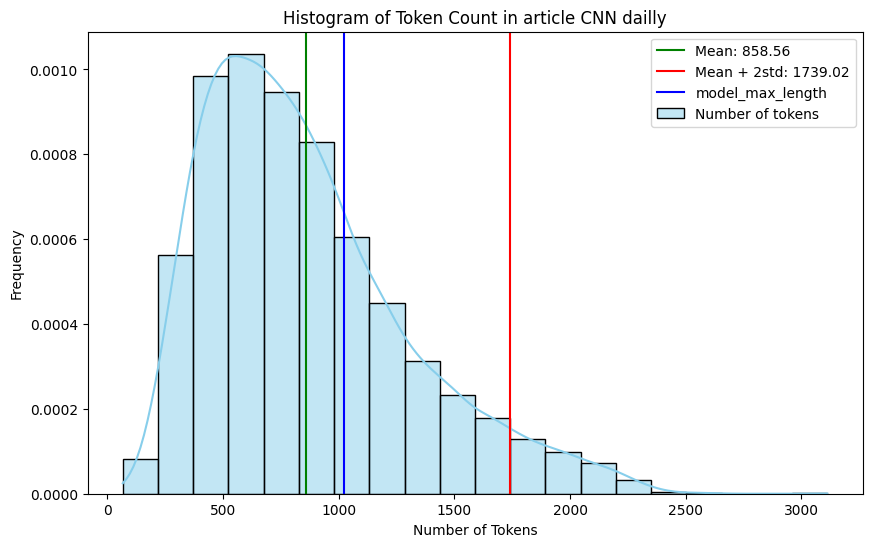

In [44]:

# Create the Seaborn histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=data_len, x="input_len", bins=20, kde=True, color='skyblue', label='Number of tokens',stat="density")

# Add vertical lines for max token and mean token length
#plt.axvline(x=tokenizer.model_max_length, color='r', linestyle='--', label=f'Max token: {tokenizer.model_max_length}')
plt.axvline(x=data_len["input_len"].mean(), color='g', linestyle='-', label=f'Mean: {data_len["input_len"].mean():.2f}')
plt.axvline(x=(data_len["input_len"].mean() + 2*data_len["input_len"].std()), color='r', linestyle='-', label=f'Mean + 2std: {data_len["input_len"].mean() + 2 *data_len["input_len"].std():.2f}')
plt.axvline(x=1024, color='b', linestyle='-', label='model_max_length')

# Add title, labels, and legend
plt.title('Histogram of Token Count in article CNN dailly')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()

# Display the plot
plt.show()


In [45]:
(data_len["input_len"] > 1024).sum()/ len(data_len["target_len"])

0.29216710182767625

## target len and generate len 

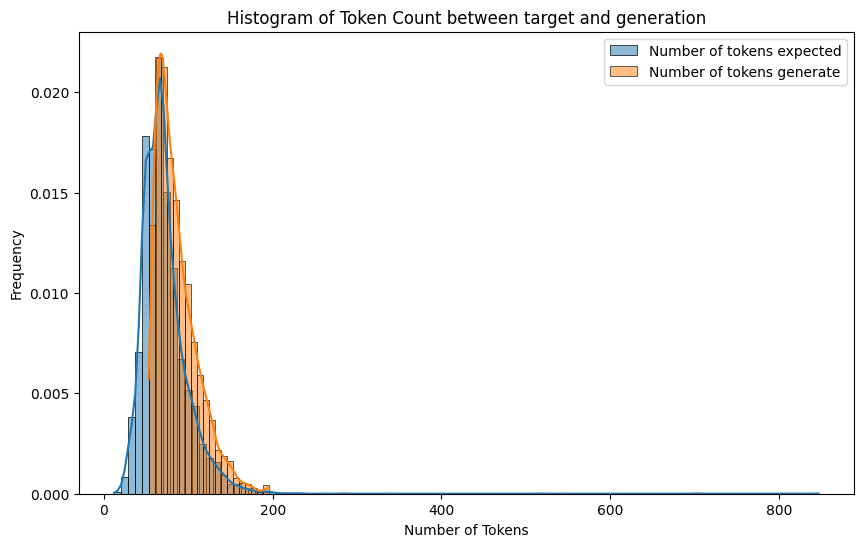

In [26]:

# Create the Seaborn histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=data_len, x="target_len", bins=100, kde=True, label='Number of tokens expected',stat="density")
sns.histplot(data=data_len, x="generate_len", bins=20, kde=True, label='Number of tokens generate',stat="density")
# Add title, labels, and legend
plt.title('Histogram of Token Count between target and generation')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()

# Display the plot
plt.show()


## Compression ratio distribution

In [52]:
data_len.describe()

,input_len,target_len,generate_len,compression_ratio
count,11490.000000,11490.000000,11490.000000,11490.000000
mean,858.563969,72.049869,86.361619,10.476844
std,440.230117,28.992050,24.895678,9.544727
min,66.000000,12.000000,53.000000,1.096163
25%,524.000000,54.000000,67.000000,6.263982
50%,772.000000,67.000000,80.000000,9.053284
75%,1095.000000,83.000000,100.000000,13.072520
max,3112.000000,847.000000,196.000000,747.872340


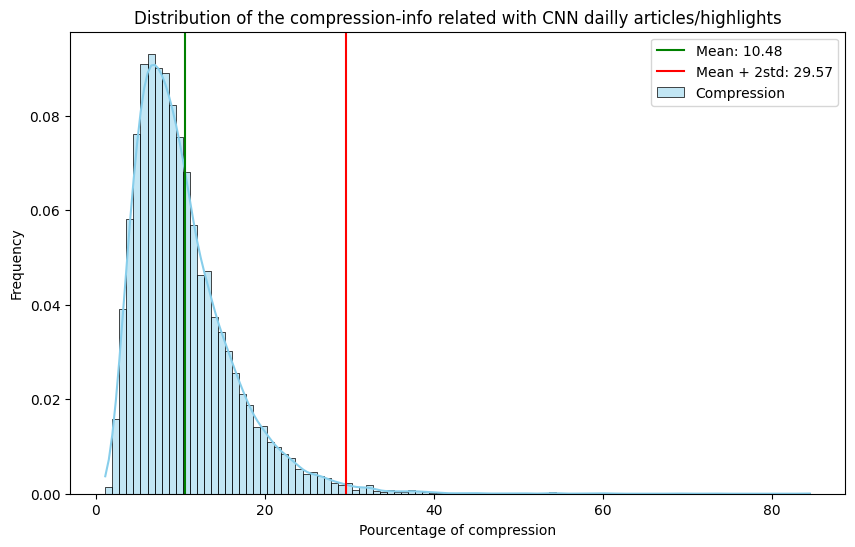

In [59]:
# Create the Seaborn histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=data_len[data_len.compression_ratio <=100], x="compression_ratio", bins=100, kde=True, color='skyblue', label='Compression',stat="density")

# Add vertical lines for max token and mean token length
#plt.axvline(x=tokenizer.model_max_length, color='r', linestyle='--', label=f'Max token: {tokenizer.model_max_length}')
plt.axvline(x=data_len["compression_ratio"].mean(), color='g', linestyle='-', label=f'Mean: {data_len["compression_ratio"].mean():.2f}')
plt.axvline(x=(data_len["compression_ratio"].mean() + 2*data_len["compression_ratio"].std()), color='r', linestyle='-', label=f'Mean + 2std: {data_len["compression_ratio"].mean() + 2 *data_len["compression_ratio"].std():.2f}')

# Add title, labels, and legend
plt.title('Distribution of the compression-info related with CNN dailly articles/highlights')
plt.xlabel('Pourcentage of compression')
plt.ylabel('Frequency')
plt.legend()

# Display the plot
plt.show()


In [58]:

print(len(data_len[data_len.compression_ratio <=100])/ len(data_len))
data_len[data_len.compression_ratio >100].shape

0.9996518711923411


(4, 5)